# Produce inputs and their corresponding targets

In [1]:
# Produce inputs and their corresponding targets
# Aim : To produce a data genertor for our model
import tensorflow as tf
from keras.optimizers import Adam
import numpy as np
import pickle
import os
from sklearn.utils import shuffle

# #_______________________________________________________________________
save_path = '../Data/'

with open(os.path.join(save_path, "train_data.pickle"), 'rb') as f:
    (train_data, train_range) = pickle.load(f)

with open(os.path.join(save_path, "val_data.pickle"), 'rb') as f:
    (val_data, val_range) = pickle.load(f)

rng = np.random.RandomState(seed=42)
# ____________________________________________________________________


def get_batch(batch_size, s="train"):  # defualt training set

    image_data = train_data if s == "train" else val_data

    if len(image_data.shape) == 5:
        (no_of_classes, no_of_images, height, width, scale) = image_data.shape
    else:
        (no_of_classes, no_of_images, height, width) = image_data.shape
        scale = 1 

    class_categories = rng.choice(
        no_of_classes, size=(batch_size,), replace=False)

    # initialize container to store pair of images and their corresponding targets
    empty_image = np.zeros((batch_size, height, width, scale))
    pairs = [empty_image for i in range(2)]
    targets = np.zeros((batch_size,))

    # set 2nd half of targets to 1
    targets[(batch_size // 2):] = 1

    # insert pairs logic
    for i in range(batch_size):
        category_1 = class_categories[i]

        # each category has 20 images so we select a random one
        index_1 = rng.randint(0, no_of_images)
        index_2 = rng.randint(0, no_of_images)
        # fill 1st image i.e. pairs[0]

        pairs[0][i, :, :, :] = image_data[category_1,
                                          index_1].reshape(width, height, scale)
        # now we fill 2nd image according to our target label
        if i >= (batch_size//2):
            category_2 = category_1  # same characters(may be different images)
        else:
            # category is an integer less than or equal to no_of_classes,
            # hence we add any random integer(not equal to zero) to get new category
            # which will represent new class
            category_2 = (category_1 + rng.randint(1,
                          no_of_classes)) % no_of_classes
            # % ensures that the new value is with in the bound

        # fill 2nd image
        pairs[1][i, :, :, :] = image_data[category_2,
                                          index_2].reshape(width, height, scale)
    return pairs, targets

# ________________________________________________________________________________________________-


def data_generator(batch_size, s="train"):
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield pairs, targets


# Test Data Generation
# 1. function to generate pairs of test images and support set.
# 2. we fill array for test images to N copies of one class (N user defined)
# 3. support set will contain N classes, which will include the above class


def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = train_data
        categories = train_range
    else:
        X = val_data
        categories = val_range

    if len(X.shape) == 5:
        (n_classes, n_examples, w, h, s) = X.shape
    else:
        (n_classes, n_examples, w, h) = X.shape
        s = 1 

    indices = rng.randint(0, n_examples, size=(N,))
    if language is not None:  # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError(
                "This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size=(N,), replace=False)

    else:  # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes), size=(N,), replace=False)
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray(
        [X[true_category, ex1, :, :]]*N).reshape(N, w, h,s)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h,s)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(
        targets, test_image, support_set)
    pairs = [test_image, support_set]

    return pairs, targets

# ________________________________________________________________)_______________________________

# #### Testing the model
# 1. now we use above function to get test data
# 2. predict this data with the model
# 3. print relevant information


def test_oneshot(model, N, k, s="val", verbose=0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct, N))
    return percent_correct
######################################################################################################################


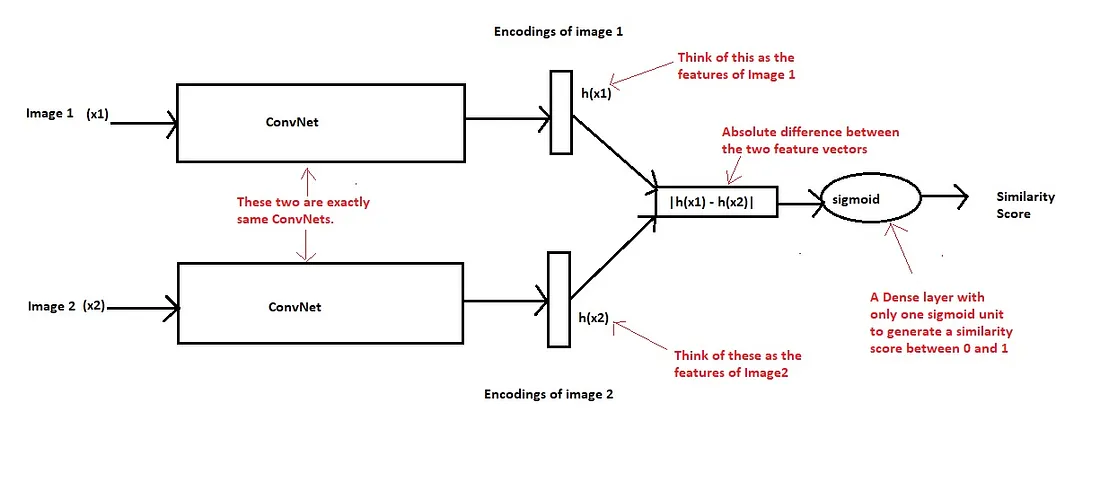

In [2]:
import cv2
from IPython.display import display, Image

# Read the WebP image using OpenCV
webp_image = cv2.imread('model.webp')

# Convert the image to PNG format (or any other compatible format)
png_image = cv2.imencode('.png', webp_image)[1].tobytes()

# Display the PNG image
display(Image(data=png_image))

# Train the model

In [3]:
import time
import os
from keras.optimizers import Adam
import numpy as np
from keras.callbacks import ModelCheckpoint
from model_architecture import get_model


c:\Users\satha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 38,960,448 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import os
from keras.optimizers import Adam
input_shape=(105,105,3)
# Assuming get_model is defined in model_architecture.py
# from model_architecture import get_model

def get_iteration_from_filename(filename):
    return int(filename.split('.')[1])

def get_max_iteration_and_model(model_path):
    # Get list of all weight files
    weight_files = os.listdir(model_path)

    # Filter out non-weight files and extract iteration numbers
    iteration_weights = [(get_iteration_from_filename(file), file) for file in weight_files if file.endswith('.weights.h5')]

    if iteration_weights:
        # Select the weight file with maximum iteration number
        max_iteration_file = max(iteration_weights, key=lambda x: x[0])[1]
        max_iteration = iteration_weights[-1][0]  # Get maximum iteration number
        model = get_model(input_shape=(105,105,3))
        model.load_weights(os.path.join(model_path, max_iteration_file))
        return max_iteration, model
    else:
        return 0, None  # No weight files found

model_path = './weights/'
max_iteration, model = get_max_iteration_and_model(model_path)

if model is not None:
    print("Loaded model with maximum iteration:", max_iteration)
    optimizer = Adam(learning_rate=0.00006)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    # Additional code using the loaded model
else:
    print("No weight files found in the specified path.")


Loaded model with maximum iteration: 50


In [5]:
# max_iteration = 0
# from model_architecture import get_model
# input_shape=(105,105,3)
# model = get_model(input_shape)

# optimizer = Adam(learning_rate=0.00006)
# model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

### Hyperparameters

In [6]:
batch_size= 32
n_iter = 20000
class_size = 20
test_size = 250
best_case = -1
evaluate_every = 50

In [7]:
t_start = time.time()
save_path = '.\weights'
print("Starting training process!")
print("-------------------------------------")
for i in range( 1, n_iter +1):
    (inputs, targets) = next(data_generator(batch_size))
    loss = model.train_on_batch(inputs,targets)

    # we want to evaluate model every 'evaluate_every' iterations
    if ( i % evaluate_every ) == 0:
        print("\n______b________________\n")
        print("Time for {0} iterations : {1} minutes".format(  i + max_iteration, (time.time()- t_start)/ 60.0  )  )
        print(f"Train Loss: {loss}")
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(test_size,class_size))
        val_accuracy= test_oneshot(model, class_size, test_size, verbose=True)
        print(f"Got an average of {val_accuracy}% {class_size} way one-shot learning accuracy \n")
        model.save_weights(os.path.join(save_path, 'weights.{}.weights.h5'.format(i+max_iteration)))

        if val_accuracy >= best_case:
            print("Current best: {0}, previous best: {1}".format(val_accuracy, best_case))
            best_case = val_accuracy     


Starting training process!
-------------------------------------



______b________________

Time for 100 iterations : 2.897578493754069 minutes
Train Loss: [array(2.599852, dtype=float32), array(0.5, dtype=float32)]
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━

: 

In [ ]:
#Train Loss: 0.6931471824645996